<a href="https://colab.research.google.com/github/AdnaneMOUZAOUI/Analyse-de-sentiments-machine-learning/blob/Reviews-Analysis/TF_IDF_3XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install xgboost

In [ ]:
# pip install shap

In [ ]:
# import nltk
# nltk.download('stopwords')

In [ ]:
# Importer le fichier depuis le drive
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import re
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
# df=df.rename(columns={"nom_client":"client","date_achat":"date_commande","date_avis":"date","text_avis":"Text","titre_avis":"Titre","note_avis":"star"})

In [ ]:
df = pd.read_csv('commentaires_prepares.csv', index_col=[0])
df=df.dropna(axis=0,how='any')
df=df.rename(columns={"Commentaire":"Text"})
df['Text'] = df['Text'].apply(lambda x: ' '.join(re.findall(r"'(\w+)'", x)))
display(df['Text'].head())

0    jamais reçu commande écris showroomprive clôtu...
1    commandé collier lun ok lautre tout celui comm...
2    commandé airpods reconditionnés dit excellent ...
3    produit acheté septembre retourné mois attends...
4    encore commande partiellement annulée dernier ...
Name: Text, dtype: object

In [ ]:
# Création d'une nouvelle variable "star_cluster" pour séparer le jeu de données en 2 segments,
# le segment des avis positifs (=1) et le segment des avis négatifs (=0)

# df['Sentiment'] = df['star']
df['Sentiment'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)
df=df[["Text","Sentiment"]]
df["Text"].fillna('', inplace=True)
df

,Text,Sentiment
0,jamais reçu commande écris showroomprive clôtu...,0
1,commandé collier lun ok lautre tout celui comm...,0
2,commandé airpods reconditionnés dit excellent ...,0
3,produit acheté septembre retourné mois attends...,0
4,encore commande partiellement annulée dernier ...,0
...,...,...
168892,satisfaite commande,1
168893,très bien très rapide satisfaite commande,1
168894,commandé mi octobre pouvoir recevoir invités f...,0
168895,lorsque vu toile site cela plu pensais queffec...,0


In [ ]:
# Séparer la variable explicative de la variable à prédire
X, y = df.Text, df.Sentiment

# Séparer le jeu de données en données d'entraînement et données test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Réduire la taille de l'échantillon
# sample_size = int(1 * len(X_train))
# X_train = X_train.sample(n=sample_size, random_state=42)
# y_train = y_train.loc[X_train.index]

In [ ]:
# Application de TF-IDF aux avis
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2,4))
# vectorizer = TfidfVectorizer(max_features=10000, stop_words=stopwords.words('french'), ngram_range=(2,4))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
# mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
# y_train = y_train.map(mapping)
# y_test = y_test.map(mapping)

In [ ]:
import xgboost as xgb

# X_train = np.asarray(X_train)
# y_train = np.asarray(y_train)
# X_test = np.asarray(X_test)


# best : 0.1, 9, 5000


# Créer le classificateur XGBoost
clf = xgb.XGBClassifier(
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=9,
    n_jobs=-1,
    )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
#  Importer la classe classification_report
from sklearn.metrics import classification_report

# Calcul et affichage de classification_report
print( classification_report(y_test, y_pred) )

# Calcul et affichage de la matrice de confusion
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.84      0.70      0.77     20276
           1       0.82      0.91      0.86     30392

    accuracy                           0.83     50668
   macro avg       0.83      0.81      0.82     50668
weighted avg       0.83      0.83      0.83     50668



Classe prédite,0,1
Classe réelle,,
0,14268,6008
1,2682,27710


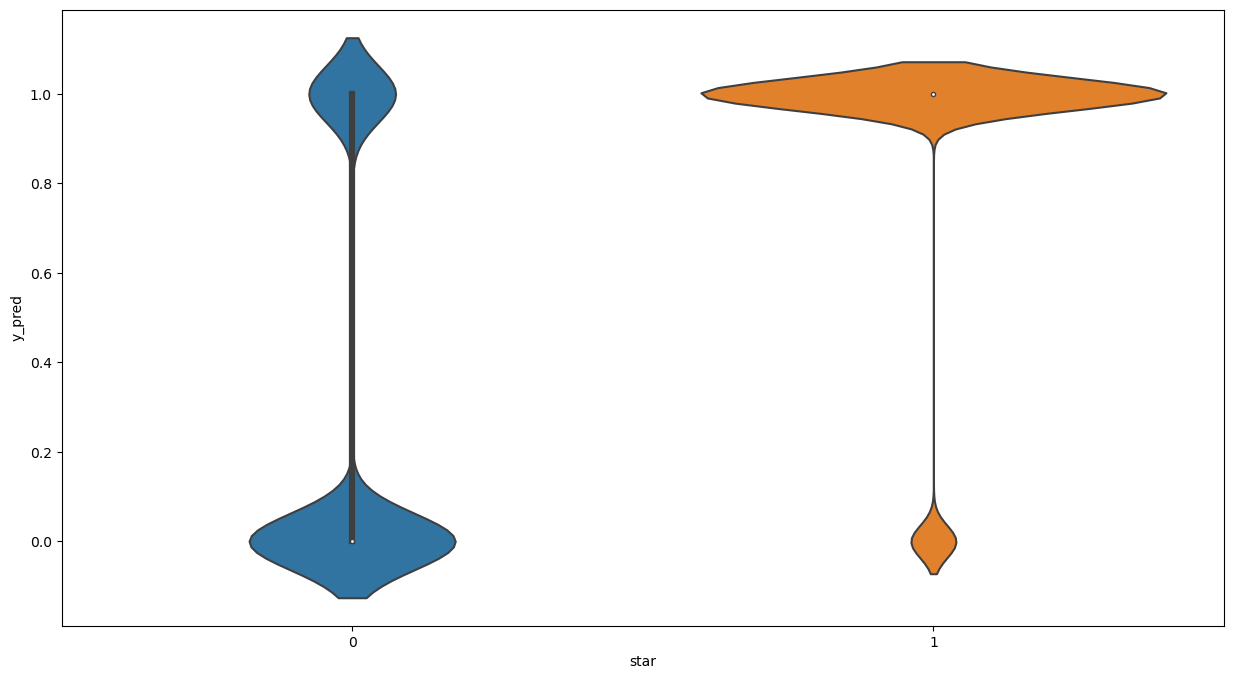

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)
data = pd.DataFrame({'star': y_test.values})
data['y_pred'] = y_pred
fig, ax = plt.subplots(figsize=[15,8])
sns.violinplot(x="star", y="y_pred", data=data, ax=ax)
plt.show()

In [ ]:
import shap

explainer = shap.TreeExplainer(clf, data=X_test.toarray())

shap_values = explainer.shap_values(X_test.todense(), approximate=True, check_additivity=False)

print('Expected Value:', explainer.expected_value)

Expected Value: -80.94104689594347


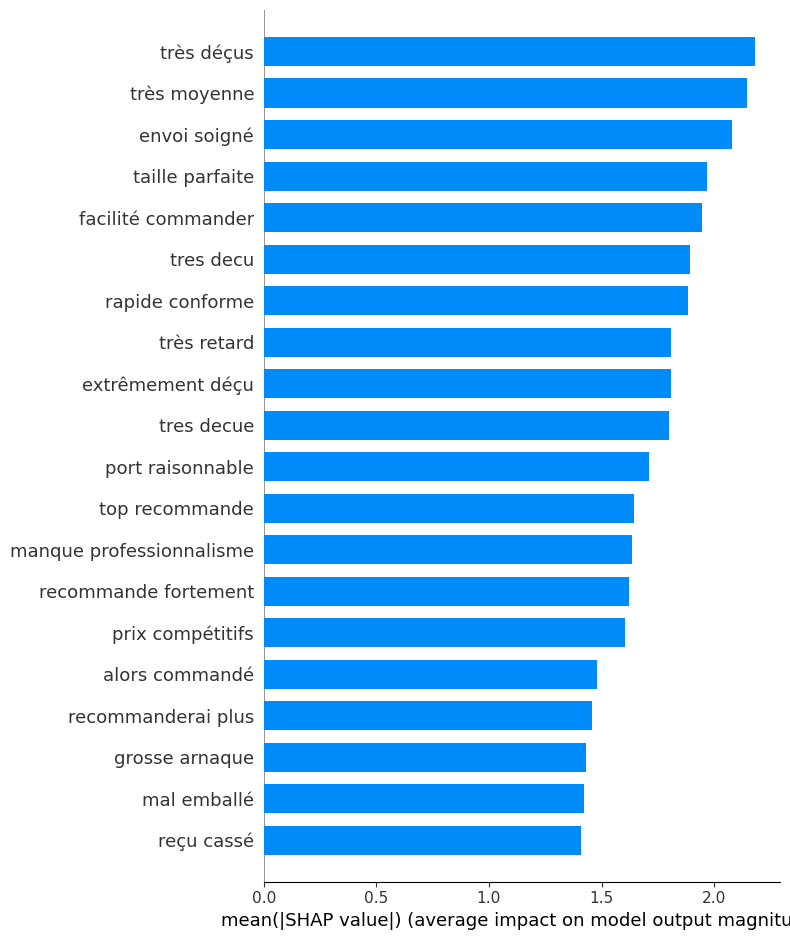

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names_out(), plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


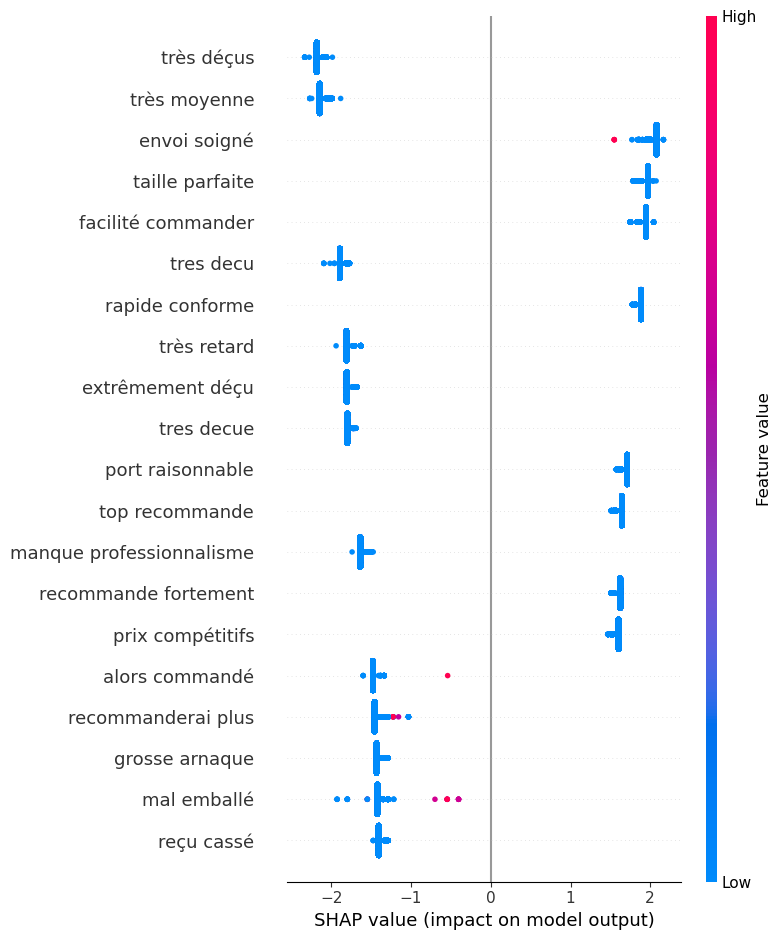

In [ ]:
shap.summary_plot(shap_values, X_test.toarray(), feature_names=vectorizer.get_feature_names_out())

In [ ]:
import joblib

# Sauvegarder le modèle
joblib.dump(clf, 'TFIDF1.pkl')


['TFIDF1.pkl']

In [ ]:
import joblib
# Charger le modèle à partir du fichier
clf = joblib.load('TFIDF1.pkl')

# Utiliser le modèle chargé pour effectuer des prédictions
comments = ["très déçus",
            "Je ne recommande pas"]

tokenized_comments = vectorizer.transform(comments)
clf.predict(tokenized_comments.toarray())

array([0, 0])